In [1]:
# Load required packages
import torch
from torch import nn
from matplotlib import pyplot as plt
plt.rcParams['text.usetex'] = False
import numpy as np

# register acceleration devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load Benchmark Data

out = np.load('training-val-test-data.npz')
th_data = out['th'] #th[0],th[1],th[2],th[3],...
u_data = out['u'] #u[0],u[1],u[2],u[3],...
testStartIndex = len(u_data)//20
u_data_small = u_data[:-(testStartIndex+1)]
th_data_small = th_data[:-(testStartIndex+1)]


from sklearn import model_selection
u_train, u_val, y_train, y_val= model_selection.train_test_split(u_data_small, th_data_small, shuffle=False, test_size=0.2,random_state=42)
# Standardization
u_mean, u_std = np.mean(u_train),np.std(u_train)
y_mean, y_std = np.mean(y_train),np.std(y_train)


### Data to train and validate on ###:
u_train = (u_train-u_mean)/u_std #normalize
y_train = (y_train-y_mean)/y_std

u_val = (u_val-u_mean)/u_std
y_val = (y_val-y_mean)/y_std

convert = lambda x: [torch.tensor(xi,dtype=torch.float64,device=device) for xi in x]


cuda


In [2]:
class simple_encoder_RNN(nn.Module):
    def __init__(self, n_hidden_encoder, n_hidden_states, n_hidden_h2o, n_encoder=20):
        super(simple_encoder_RNN, self).__init__()
        self.n_hidden_states = n_hidden_states
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out, n_hidden: nn.Sequential(nn.Linear(n_in,n_hidden),nn.ReLU(),nn.Linear(n_hidden,n_out)) #short hand for a 1 hidden layer NN
        self.rnn = nn.RNN(input_size=self.input_size,  hidden_size=n_hidden_states,  batch_first=True, nonlinearity='relu').double() #i)
        self.h2o = net(n_hidden_states + self.input_size, self.output_size, n_hidden_h2o).double() #i)
        self.hEncoder = net(n_encoder*2,n_hidden_states,n_hidden_encoder).double()

    def forward(self, inputs, hist):
        h0 = self.hEncoder(hist)
        hiddens, h_n = self.rnn(inputs[:,:,None],h0[None,:,:]) #i)
        combined = torch.cat((hiddens,inputs[:,:,None]),dim=2) #i)
        if False: #two ways to solve this #i)
            y_predict = [] #i)
            for i in range(combined.shape[1]):  #i)
                y_predict.append(self.h2o(combined[:,i,:])[:,0])  #i)
            y_predict = torch.stack(y_predict,dim=1)  #i)
        else: #this is faster but more complex #i)
            #reshape from (N_batch, N_time, N_hidden) to (N_batch*N_time, N_hidden) #i)
            h2o_input = combined.view(-1,self.n_hidden_states+self.input_size) #i)
            #apply and reshape from (N_batch*N_time,1) to (N_batch,N_time) #i)
            y_predict =  self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])  #new #i)

        return y_predict

class simple_lstm(nn.Module):
    def __init__(self, n_hidden_states, n_encoder=20):
        super(simple_lstm, self).__init__()
        self.n_hidden_states = n_hidden_states
        self.input_size = 1
        self.output_size = 1
        net = lambda n_in,n_out: nn.Sequential(nn.Linear(n_in,40),nn.Sigmoid(),nn.Linear(40,n_out)) #short hand for a 1 hidden layer NN
        self.lstm = nn.LSTM(input_size=self.input_size,  hidden_size=n_hidden_states,  batch_first=True).double() #i)
        self.h2o = net(n_hidden_states + self.input_size, self.output_size).double() #i)
        self.hEncoder = net(n_encoder*2,n_hidden_states).double()
        self.cEncoder = net(n_encoder*2,n_hidden_states).double()

    def forward(self, inputs, hist):
        h0 = self.hEncoder(hist)
        c0 = self.cEncoder(hist)
        hiddens, (h_n, c_n) = self.lstm(inputs[:,:,None],(h0[None,:,:],c0[None,:,:])) #i)
        #hiddens, h_n = self.lstm(inputs[:,:,None]) #i)
        combined = torch.cat((hiddens,inputs[:,:,None]),dim=2) #i)
        if False: #two ways to solve this #i)
            y_predict = [] #i)
            for i in range(combined.shape[1]):  #i)
                y_predict.append(self.h2o(combined[:,i,:])[:,0])  #i)
            y_predict = torch.stack(y_predict,dim=1)  #i)
        else: #this is faster but more complex #i)
            #reshape from (N_batch, N_time, N_hidden) to (N_batch*N_time, N_hidden) #i)
            h2o_input = combined.view(-1,self.n_hidden_states+self.input_size) #i)
            #apply and reshape from (N_batch*N_time,1) to (N_batch,N_time) #i)
            y_predict =  self.h2o(h2o_input).view(inputs.shape[0],inputs.shape[1])  #new #i)

        return y_predict

def make_OE_init_state_data(udata, ydata, nf=100, n_encode=20):
    U = []
    Y = []
    hist = []
    for k in range(nf+n_encode,len(udata)+1):
        hist.append(np.concatenate((udata[k-nf-n_encode:k-nf], ydata[k-nf-n_encode:k-nf]))) #f)
        U.append(udata[k-nf:k]) #f)
        Y.append(ydata[k-nf:k]) #f)
    return np.array(hist), np.array(U), np.array(Y)


In [6]:
#'n_future': 40, 'n_hidden_encoder': 16, 'n_hidden_states': 32, 'n_hidden_h2o': 32, 'n_encoder': 10

nfuture = 40
n_encode = 10
n_burn = 0

convert = lambda x: [torch.tensor(xi, dtype=torch.float64,device=device) for xi in x]
histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=nfuture,            n_encode=n_encode))
histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=len(u_val)-n_encode, n_encode=n_encode))


#model = simple_lstm(n_hidden_states=10,n_encoder=n_encode)
model = simple_encoder_RNN(n_hidden_encoder=16,n_hidden_states=32,n_hidden_h2o=32,n_encoder=n_encode)
model = model.to(device=device) # Move the model to the GPU
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
batch_size = 64
ids = np.arange(len(Utrain),dtype=int)
for epoch in range(50):
    model.train()
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size]
        Uin = Utrain[ids_now]
        histin = histtrain[ids_now]
        Yout = model.forward(inputs=Uin,hist=histin)
        Yin = Ytrain[ids_now]
        Loss = torch.mean((Yin[:,n_burn:] - Yout[:,n_burn:])**2)
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

    with torch.no_grad():
        model.eval()
        Loss_val = torch.mean((model(inputs=Uval,hist=histval)[:,n_burn:] - Yval[:,n_burn:])**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain,hist=histtrain)[:,n_burn:] - Ytrain[:,n_burn:])**2)**0.5
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():.2%}, Train Loss={Loss_train.item():.2%}, Validation Loss absolute={Loss_val.item() * y_std}')

epoch=0, Validation Loss=43.63%, Train Loss=24.64%, Validation Loss absolute=0.20468621859751077
epoch=1, Validation Loss=46.66%, Train Loss=25.22%, Validation Loss absolute=0.21894213512907157
epoch=2, Validation Loss=47.85%, Train Loss=24.29%, Validation Loss absolute=0.22449496101181257
epoch=3, Validation Loss=39.67%, Train Loss=22.37%, Validation Loss absolute=0.18613543572313043
epoch=4, Validation Loss=47.79%, Train Loss=24.04%, Validation Loss absolute=0.2242283995692799
epoch=5, Validation Loss=31.16%, Train Loss=20.43%, Validation Loss absolute=0.14618730245899653
epoch=6, Validation Loss=35.65%, Train Loss=20.30%, Validation Loss absolute=0.16726281544535482
epoch=7, Validation Loss=36.25%, Train Loss=16.36%, Validation Loss absolute=0.1700966205431564
epoch=8, Validation Loss=34.77%, Train Loss=16.66%, Validation Loss absolute=0.1631229409397122
epoch=9, Validation Loss=37.47%, Train Loss=17.82%, Validation Loss absolute=0.1758133515367657
epoch=10, Validation Loss=34.14%, 

In [4]:
# Grid search

# Code from Exercise Set L3
def fit(net, Utrain, Ytrain, histtrain, Uval, Yval, histval, batch_size=64, epochs=50):
    optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
    best_state = None
    best_loss = float('inf')
    ids = np.arange(len(Utrain),dtype=int)
    for epoch in range(1,epochs+1):
        net.train()
        for i in range(0,len(Utrain),batch_size):
          ids_now = ids[i:i+batch_size]
          Uin = Utrain[ids_now]
          histin = histtrain[ids_now]
          Yout = net(inputs=Uin,hist=histin)
          Yin = Ytrain[ids_now]
          loss = torch.mean((Yin[:,:] - Yout[:,:])**2)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        if epoch%10==0:
            with torch.no_grad():
              loss_val = torch.mean((net(inputs=Uval,hist=histval)[:,:] - Yval[:,:])**2)**0.5
              if loss_val<best_loss:
                  from copy import deepcopy
                  best_state = deepcopy(net.state_dict())
                  best_loss = loss_val
              print(f'epoch={epoch}, loss={y_std * loss.item()**0.5:.3f}')
    if best_state:
        net.load_state_dict(best_state)
    return net

import functools
@functools.lru_cache(maxsize=500, typed=False)
def test(n_future, n_hidden_encoder, n_hidden_states, n_hidden_h2o, n_encoder=20):
    net = simple_encoder_RNN(n_hidden_encoder, n_hidden_states, n_hidden_h2o, n_encoder) #a=)
    net = net.to(device)
    histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=n_future,            n_encode=n_encoder))
    histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=len(u_val)-n_encoder, n_encode=n_encoder))
    net = fit(net, Utrain, Ytrain, histtrain, Uval, Yval, histval, epochs=30) #a=)
    net.eval()
    RMS = y_std * torch.mean((net(inputs=Uval,hist=histval)[:,:]-Yval[:,:])**2).item()**0.5 #a=)
    return RMS #a=)


current_best = dict(n_future=30, n_hidden_encoder=16, n_hidden_states=8, n_hidden_h2o=16, n_encoder=10)
choices_dict = dict(n_future=[30,40], \
                n_hidden_encoder=[16,32,64], \
                n_hidden_states=[8,16,32], \
                n_hidden_h2o=[16,32,64], \
                n_encoder = [10,20]
                )
import itertools
gridKeys = choices_dict.keys()
grid = list(itertools.product(*choices_dict.values()))

# rmse_matrix = np.zeros((len(choices_dict["na"]), len(choices_dict["nb"])))

best_score = float('inf')
best_params = None
results = []
import copy
for params in grid:
    choice = dict(zip(gridKeys,params))
    # now = copy.deepcopy(current_best) #create a new dict
    # now[name] = choice #put choice in the correct place
    print('optimizing...',choice)

    rmse = test(**choice)
    results.append((choice, rmse)) #add it to results


    if rmse < best_score:
        best_score = rmse
        best_params = choice



optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 16, 'n_encoder': 10}
epoch=10, loss=0.082
epoch=20, loss=0.076
epoch=30, loss=0.075
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 16, 'n_encoder': 20}
epoch=10, loss=0.085
epoch=20, loss=0.063
epoch=30, loss=0.049
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 32, 'n_encoder': 10}
epoch=10, loss=0.042
epoch=20, loss=0.049
epoch=30, loss=0.048
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 32, 'n_encoder': 20}
epoch=10, loss=0.051
epoch=20, loss=0.050
epoch=30, loss=0.043
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 64, 'n_encoder': 10}
epoch=10, loss=0.043
epoch=20, loss=0.041
epoch=30, loss=0.041
optimizing... {'n_future': 30, 'n_hidden_encoder': 16, 'n_hidden_states': 8, 'n_hidden_h2o': 64, 'n_encoder': 20}
e

In [5]:
import pickle
with open("grid_search_RNN","wb") as f:
  pickle.dump(results,f)

print(best_params)

{'n_future': 40, 'n_hidden_encoder': 16, 'n_hidden_states': 32, 'n_hidden_h2o': 32, 'n_encoder': 10}


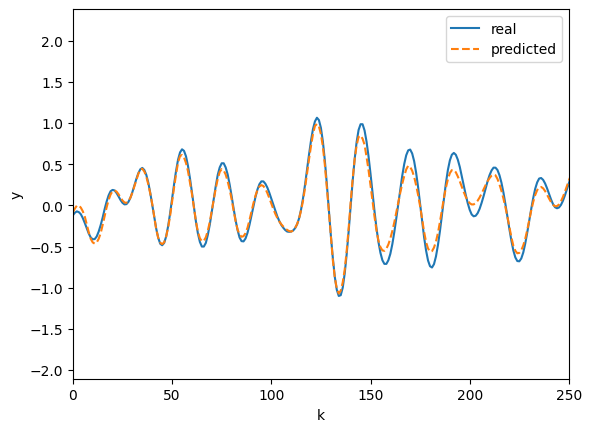

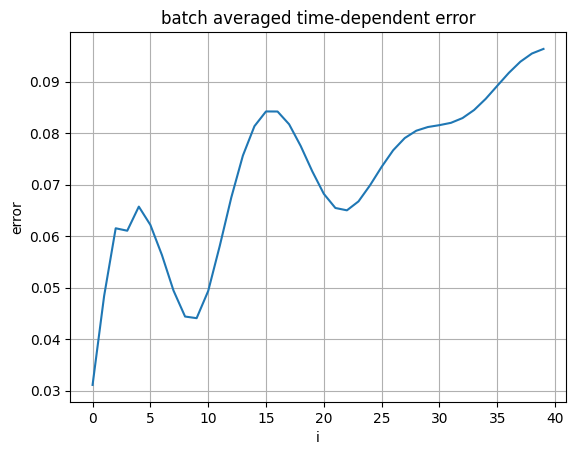

train prediction errors:
RMS: tensor(0.1175, device='cuda:0', dtype=torch.float64) radians
RMS: tensor(6.7340, device='cuda:0', dtype=torch.float64) degrees
NRMS: tensor(25.0495, device='cuda:0', dtype=torch.float64) %


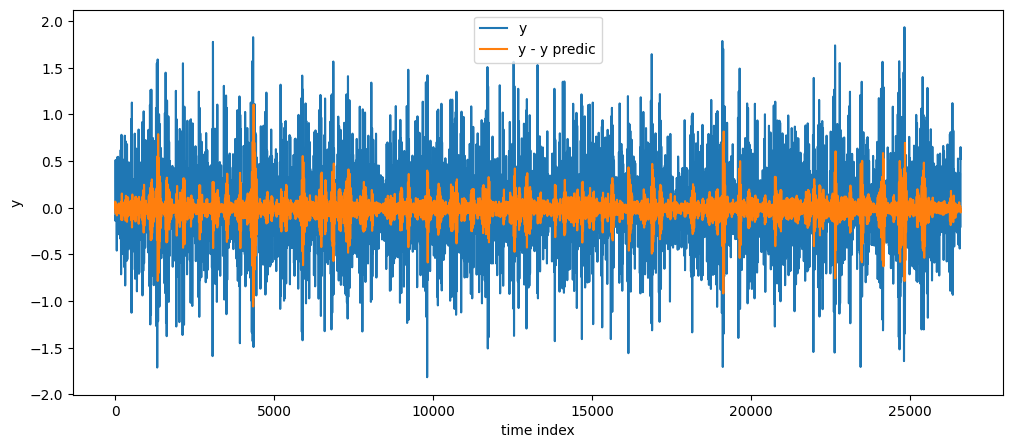

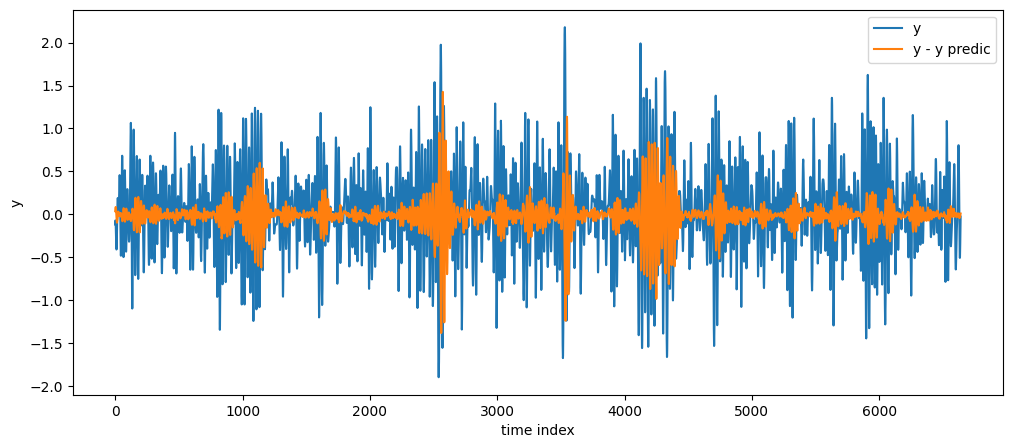

validation prediction errors:
RMS: tensor(0.1821, device='cuda:0', dtype=torch.float64) radians
RMS: tensor(10.4308, device='cuda:0', dtype=torch.float64) degrees
NRMS: tensor(34.7773, device='cuda:0', dtype=torch.float64) %


In [7]:


with torch.no_grad():
    plt.plot((Yval[0]*y_std + y_mean).cpu())
    model.eval()
    plt.plot((model(inputs=Uval,hist=histval)[0] * y_std + y_mean).cpu(),'--')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.xlim(0,250)
    plt.legend(['real','predicted'])
    plt.show()
    model.eval()
    plt.plot(y_std*np.mean(((Ytrain-model(inputs=Utrain,hist=histtrain))).cpu().numpy()**2,axis=0)**0.5) #average over the error in batch
    plt.title('batch averaged time-dependent error')
    plt.ylabel('error')
    plt.xlabel('i')
    plt.grid()
    plt.show()

    model.eval()
    histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(u_train, y_train, nf=nfuture,            n_encode=n_encode))
    histval,   Uval,   Yval   = convert(make_OE_init_state_data(u_val,   y_val,   nf=len(u_val)-n_encode, n_encode=n_encode))
    histTrainEval, UTrainEval, YTrainEval = convert(make_OE_init_state_data(u_train, y_train, nf=len(u_train)-n_encode, n_encode=n_encode))

    Ytrain = YTrainEval[0] * y_std + y_mean
    Ytrain_pred = model(inputs=UTrainEval,hist=histTrainEval)[0] * y_std + y_mean
    print('train prediction errors:')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5,'radians')
    print('RMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Ytrain_pred-Ytrain)**2)**0.5/y_std*100,'%')
    res = Ytrain_pred - Ytrain #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Ytrain.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    #plt.xlim(0,250)
    plt.show() #b)

    Yval = Yval[0] * y_std + y_mean
    Yval_pred = model(inputs=Uval,hist=histval)[0] * y_std + y_mean
    res = Yval_pred - Yval #b)
    plt.figure(figsize=(12,5)) #b)
    plt.plot(Yval.cpu()) #b)
    plt.plot(res.cpu()) #b)
    plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y predic'])#b)
    plt.show() #b)
    print('validation prediction errors:')
    print('RMS:', torch.mean((Yval_pred-Yval)**2)**0.5,'radians')
    print('RMS:', torch.mean((Yval_pred-Yval)**2)**0.5/(2*np.pi)*360,'degrees')
    print('NRMS:', torch.mean((Yval_pred-Yval)**2)**0.5/Yval.std()*100,'%')

trained simulation errors:
RMS: 0.11114768090729454 radians
RMS: 6.368293018654778 degrees
NRMS: 23.187779507261805 %


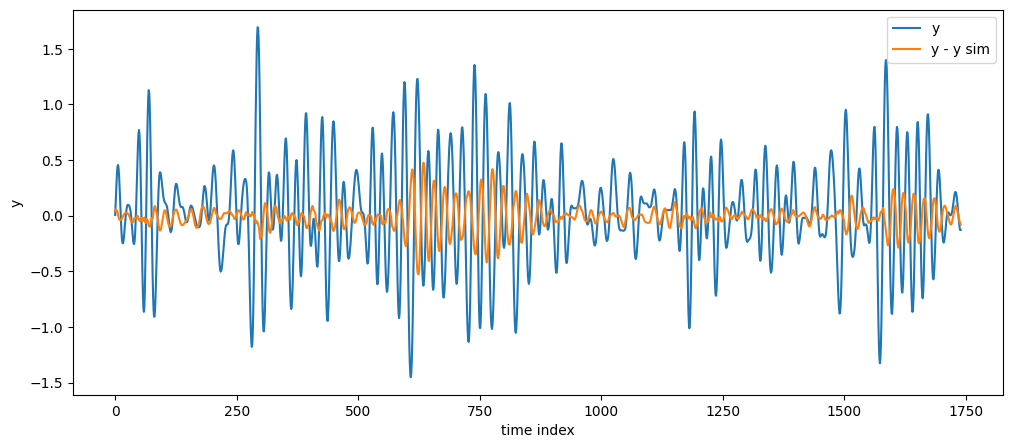

test simulation errors:
RMS: 0.051294564204841867 radians
RMS: 2.9389620409002646 degrees
NRMS: 155.81954504861207 %


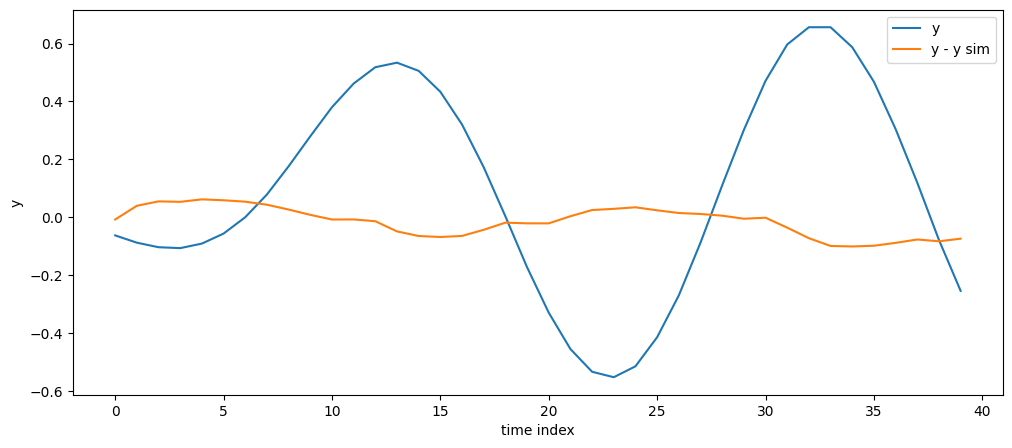

In [8]:
# Set up simulation for identified net
#### What's done with the na and nb here???
# Simulation Test
out = np.load('/content/training-val-test-data.npz')
th_train = out['th'] #th[0],th[1],th[2],th[3],...
u_train = out['u'] #u[0],u[1],u[2],u[3],...

data = np.load('/content/hidden-test-simulation-submission-file.npz')
u_test = data['u']
th_test = data['th'] #only the first 50 values are filled the rest are zeros


def simulation_IO_model(f, ulist, ylist, skip=50):
    upast = ulist[skip-n_encode:skip].tolist() #good initialization
    ypast = ylist[skip-n_encode:skip].tolist()
    hist = np.concatenate([(upast-u_mean)/u_std,(ypast-y_mean)/y_std],axis=0)
    inputs = (np.array(ulist[skip:].tolist()) - u_mean)/u_std
    hist, inputs = convert([hist[None,:], inputs[None,:]])
    ypred = f(inputs,hist).cpu().detach().numpy() * y_std + y_mean
    Y = np.concat([ylist[:skip],ypred])
    return np.array(Y)

skip = n_encode
model.eval()
th_train_sim = simulation_IO_model(lambda x, hist: model.forward(inputs=x,hist=hist)[0], u_train[-testStartIndex:], th_train[-testStartIndex:], skip=skip)
print('trained simulation errors:')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[-(testStartIndex-skip):])**2)**0.5,'radians')
print('RMS:', np.mean((th_train_sim[skip:]-th_train[-(testStartIndex-skip):])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_train_sim[skip:]-th_train[-(testStartIndex-skip):])**2)**0.5/th_train.std()*100,'%')
# Plotting
res = th_train_sim[skip:] - th_train[-(testStartIndex-skip):] #b)
plt.figure(figsize=(12,5)) #b)
plt.plot(th_train[-(testStartIndex-skip):]) #b)
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y sim'])#b)
plt.show() #b)

skip = n_encode
th_test_sim = simulation_IO_model(lambda x,hist: model(x,hist)[0], u_test, th_test, skip=skip)
print('test simulation errors:')
print('RMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5,'radians')
print('RMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5/(2*np.pi)*360,'degrees')
print('NRMS:', np.mean((th_test_sim[skip:50]-th_test[skip:50])**2)**0.5/th_test.std()*100,'%')
# Plotting
res = th_test_sim[skip:50] - th_test[skip:50] #b)
plt.figure(figsize=(12,5)) #b)
plt.plot(th_test[skip:50]) #b)
plt.plot(res) #b)
plt.xlabel('time index'); plt.ylabel('y'); plt.legend(['y','y - y sim'])#b)
plt.show() #b)